    rank x_classification        date  region start_time maximum_time  \
0      1             X28+  2003/11/04     486      19:29        19:53   
1      2             X20+  2001/04/02    9393      21:32        21:51   
2      3           X17.2+  2003/10/28     486      09:51        11:10   
3      4             X17+  2005/09/07     808      17:17        17:40   
4      5            X14.4  2001/04/15    9415      13:19        13:50   
5      6              X10  2003/10/29     486      20:37        20:49   
6      7             X9.4  1997/11/06    8100      11:49        11:55   
7      8             X9.3  2017/09/06    2673      11:53        12:02   
8      9               X9  2006/12/05     930      10:18        10:35   
9     10             X8.3  2003/11/02     486      17:03        17:25   
10    11             X8.2  2017/09/10    2673      15:35        16:06   
11    12             X7.1  2005/01/20     720      06:36        07:01   
12    13             X6.9  2011/08/09    1263      

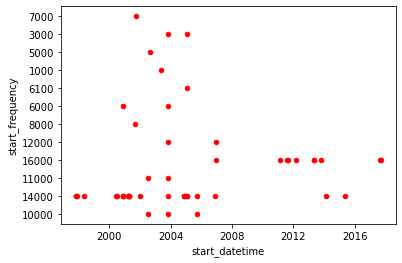

In [195]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part 1 Step 1

# Use requests to get (as in, HTTP GET) the URL
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
r = requests.get('https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares', headers=headers)

# Extract the text from the page
r.content

# Use BeautifulSoup to read and parse the data, either as html or lxml
soup = BeautifulSoup(r.content, 'html.parser')

# Use prettify() to view the content and find the appropriate table
soup.prettify()

# Use find() to save the aforementioned table as a variable
table = soup.find('table')

# read in the HTML file
dfs = pd.read_html(str(table))
df = pd.concat(dfs)
df.columns = ['rank', 'x_classification', 'date', 'region', 'start_time', 'maximum_time', 'end_time', 'movie']

print(df)

# Part 1 Step 2

# Drop the last column of the table
df = df.drop(['movie'], axis=1)

# Use datetime import to combine the date and each of the three time columns into three datetime columns
df['start_datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['start_time'].astype(str))
df['max_datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['maximum_time'].astype(str))
df['end_datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['end_time'].astype(str))
# drop the useless columns
df = df.drop(['date'], axis=1)
df = df.drop(['start_time'], axis=1)
df = df.drop(['maximum_time'], axis=1)
df = df.drop(['end_time'], axis=1)

# Set regions coded as - as missing (NaN)
df = df.replace("-", "NaN")

print(df)

# Part 1 Step 3

# get data
r2 = requests.get('https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html')
soup2 = BeautifulSoup(r2.content, 'html.parser')
soup2.prettify()

# find the appropriate text
rawdata = soup2.find('pre').text
rows = rawdata.split('\n')[12:530] 
new_rows = [data.split()[0:14] for data in rows]
df2 = pd.DataFrame (new_rows,columns=['start_date', 'start_time', 'end_date', 'end_time','start_frequency', 'end_frequency', 'flare_location', 'flare_region', 'flare_classification', 'cme_date', 'cme_time', 'cme_angle', 'cme_width', 'cme_speed'])
print(df2)

# Part 1 Step 4

# Recode any missing entries as NaN
df2 = df2.replace(['????', '----', '-----', '--:--', '--/--', 'FILA', 'altr', 'DSF', 'BACK', '------', 'EP', 'Back?', 'DIM', 'EP?'], 'NaN')

# Create a new column that indicates if a row corresponds to a halo flare or not, 
# and then replace Halo entries in the cme_angle column as NA
df2['is_halo'] = (df2['cme_angle'] == 'Halo').astype('bool')
df2['cme_angle'] = df2['cme_angle'].replace(['Halo'], 'NA')

# Create a new column that indicates if width is given as a lower bound, 
# and remove any non-numeric part of the width column.
df2['if_width_given_as_lower_bound'] = (df2['cme_width'].str.contains('>').astype('bool'))
df2.loc[df2['cme_width'].str.contains('>')] = ''

# Combine date and time columns for start, end and cme so they can be encoded as datetime objects
# create new columns
df2['start_datetime'] = df2['start_date']
df2['end_datetime'] = df2['end_date']
df2['cme_datetime'] = df2['cme_date']

for index, row in df2.iterrows():
    year = row['start_date']
    y = year[:5]
    
    row['end_date'] = y + row['end_date'] + ' ' + row['end_time']
    row['end_datetime'] = pd.to_datetime(row['end_date'], errors='coerce')
    
    row['cme_date'] = y + row['cme_date'] + ' ' + row['cme_time']
    row['cme_datetime'] = pd.to_datetime(row['cme_date'], errors='coerce')
    
    row['start_date'] = row['start_date'] + ' ' + row['start_time']
    row['start_datetime'] = pd.to_datetime(row['start_date'], errors='coerce')
    
# drop useless columns
df2 = df2.drop(['start_date'], axis=1)
df2 = df2.drop(['start_time'], axis=1)
df2 = df2.drop(['end_date'], axis=1)
df2 = df2.drop(['end_time'], axis=1)
df2 = df2.drop(['cme_date'], axis=1)
df2 = df2.drop(['cme_time'], axis=1)

df2 = df2[['start_datetime', 'end_datetime', 'start_frequency', 'end_frequency', 'flare_location', 'flare_region', 'flare_classification', 'cme_datetime', 'cme_angle', 'cme_width', 'cme_speed', 'is_halo','if_width_given_as_lower_bound']]
print(df2)

# Part 2
# Question 1
nasa_flare = df2.loc[df2['flare_classification'].str.contains('X')].copy()
nasa_flare['rating'] = nasa_flare['flare_classification'].str.replace('X', '')
nasa_flare['rating'] = nasa_flare['rating'].astype('float')
nasa_flare = nasa_flare.sort_values(by=['rating'], ascending=False)
nasa_flare = nasa_flare.head(50)
print(nasa_flare)
# No, the data is different. It seems that SpaceWeatherLive contains some data that are not shown in nasa's database. And some values are also different.

# Question 2
nasa_flare['ranking_in_spacewhetherlive'] = np.nan

#print(nasa_flare)

for index, row in nasa_flare.iterrows():
    for i, r in df.iterrows():
        if row['start_datetime'].date() == r['start_datetime'].date():
            #row['ranking_in_spacewhetherlive'] = r['rank']
            nasa_flare.at[index, 'ranking_in_spacewhetherlive'] = r['rank']

print(nasa_flare)

# Question 3
# (a) a short description (2 sentences) of what the intent of your plot  
# (b) code to produce your plot, 
# (c) a short text description of your plot, and 
# (d) a sentence or two of interpretation of your plot (again think of variation, co-variation, etc.).
nasa_flare.plot(kind='scatter',x='start_datetime',y='start_frequency',color='red')
plt.show()

# The plot is descripting the start frequency of flares in the top 50 classification over time.
# From the plot we could see the most of the flares cluster in the year around 2004 (like between 2000 to 2008). Also the highest start frequency occured during the same period of time.